# Monte Carlo Simulations + Brownian Motion For Future Price Paths

Another application of Monte Carlo simulations can be found in finance, where it can be combined with brownian motion. Brownian motion is used to model random movement over a period of time, like how stock prices behave. By using Monte Carlo simulations, we are able to roughly depict the price ranges in the future and potential downside/upside risks, assuming our parameters are correct.

Lets start with Nvidia


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

ticker = 'NVDA'
start_date = '2020-01-01'
end_date = '2025-01-01'

Lets make a function to assemble all the necessary parameters of the Brownian Motion function

In [65]:
def get_price_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)['Close']
    current_price = data.iloc[-1]
    log_returns = np.log(data / data.shift(1)).dropna()
    mu = log_returns.mean() * 252
    sigma = log_returns.std() * np.sqrt(252)
    drift = mu - (0.5 * sigma ** 2)
    return current_price, drift, sigma


This is the Brownian Motion formula we will be using:

$$
S_{t+\Delta t} = S_t \cdot \exp \Big[ (\mu - \frac{1}{2} \sigma^2)\Delta t + \sigma \sqrt{\Delta t} \, Z \Big]
$$

- $ S_{t+\Delta t} $ is the new price in the next time interval
- $ S_t $ is the previous price (newest price)
- $ \mu $ is the drift, which is calculated by the average return trend of the stock.
- $ \sigma $ is the standard deviation of log returns. We log returns because it simulates continuous returns (compounding).
- $ \Delta t $ is the time step. How long is each time interval?
- $ Z $ is the random shock. This is the random part. Everyday we will exhibit a random price movement, with the magnitude set by $ \mu $ and $ \sigma $


In [66]:
def brownian_motion(current_price, drift, sigma, days):
    dt = 1 / 252
    series = [current_price]
    for _ in range(days):
        random_shock = np.random.normal(0, 1)
        new_price = series[-1] * np.exp(drift * dt + sigma * random_shock * np.sqrt(dt))
        series.append(new_price)
    return series

Now that we have the formula implemented, we just have to plot the time series and look how they play out.

[*********************100%***********************]  1 of 1 completed


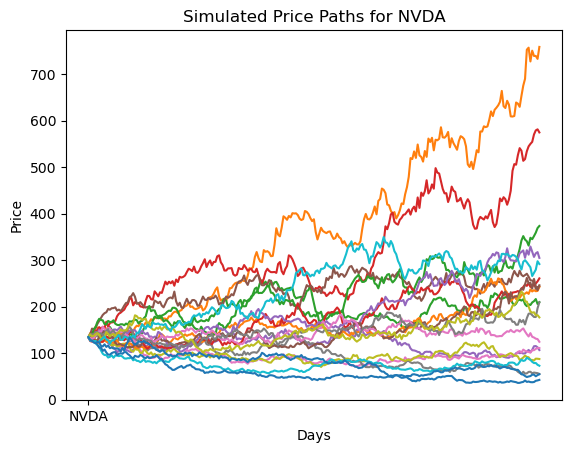

In [67]:
def plot_price_paths(current_price, drift, sigma, days, num_paths):
    final_prices = []
    plt.plot(current_price, markersize=5, label='Current Price')
    for _ in range(num_paths):
        price_path = brownian_motion(current_price, drift, sigma, days)
        final_prices.append(price_path[-1])
        plt.plot(price_path)
    plt.title(f'Simulated Price Paths for {ticker}')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()
    return final_prices

nvda_price, nvda_drift, nvda_sigma = get_price_data(ticker, start_date, end_date)
final_prices = plot_price_paths(nvda_price, nvda_drift, nvda_sigma, days=252, num_paths=20)

Lets do some basic analysis. Note: there are more ways to analyze your future price paths. We will look at expected volatility over the next year. We will also look at a 5% worse case scenario. This represents a 5% chance that we will lose x%. ES represents the average loss that will occur within this 5% margin. VaR and ES are ways to look at your downside risk. Volatility is just a gauge into how much you can expect the price of Nvidia stock to move after a year.

In [68]:
final_returns = [(price - nvda_price) / nvda_price for price in final_prices]
vol = np.std(final_returns)
final_returns = np.array(final_returns)
VaR_5 = np.percentile(final_returns, 5)
expected_shortfall_5 = np.mean([r for r in final_returns if r <= VaR_5])

print("5% Worst Case Scenarios (Downside Risk): ", VaR_5)
print("Expected Shortfall (ES) at 5%: ", expected_shortfall_5)
print("Volatility (Standard Deviation of Returns): ", vol)

5% Worst Case Scenarios (Downside Risk):  -0.5993557839127908
Expected Shortfall (ES) at 5%:  -0.6853469701165315
Volatility (Standard Deviation of Returns):  1.3066993815016703


Lets try this on a drastically different stock: Coca-Cola. Coke is known to be much less volatile and more stable, with investors often relying on Coke for dividends, not price movements.

[*********************100%***********************]  1 of 1 completed


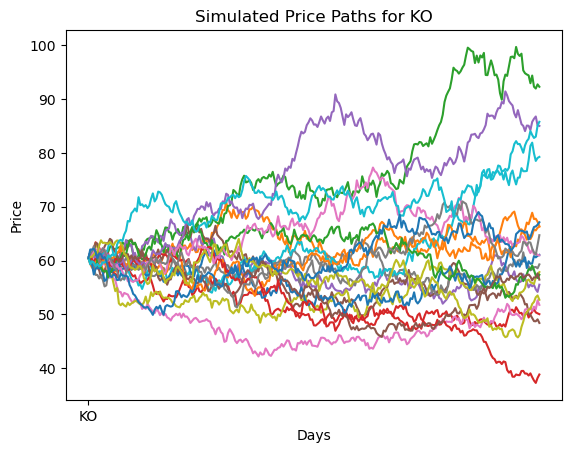

In [71]:
ticker = 'KO'
ko_price, ko_drift, ko_sigma = get_price_data(ticker, start_date, end_date)
final_prices = plot_price_paths(ko_price, ko_drift, ko_sigma, days=252, num_paths=20)


In [72]:
final_returns = [(price - ko_price) / ko_price for price in final_prices]
vol = np.std(final_returns)
final_returns = np.array(final_returns)
VaR_5 = np.percentile(final_returns, 5)
expected_shortfall_5 = np.mean([r for r in final_returns if r <= VaR_5])

print("5% Worst Case Scenarios (Downside Risk): ", VaR_5)
print("Expected Shortfall (ES) at 5%: ", expected_shortfall_5)
print("Volatility (Standard Deviation of Returns): ", vol)

5% Worst Case Scenarios (Downside Risk):  -0.2071126621798666
Expected Shortfall (ES) at 5%:  -0.3574499923909134
Volatility (Standard Deviation of Returns):  0.2198637802131244


We can see here that standard deviation is much lower, however, downside risk is also a little higher, because our drift variable is less skewed compared to Nvidia, as Nvidia is a growth stock after all.